In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids, get_sample_id_mask
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")



adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908'




In [ ]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_'+run_name+'.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']



## Visium mapping plots

In [ ]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]
    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s].copy()

    # Subset to only plot the cell types with highest mean prevalence
    cell_counts = slide.obs[adata_vis.uns['mod']['factor_names']]
    cell_type_pcts = cell_counts.div(cell_counts.sum(axis=1),axis=0)*100
    cell_types_to_plot = cell_type_pcts.mean(axis=0).sort_values(ascending=False)[:n_types].index


    # Iterate over the columns of df2
    for column in cell_type_pcts.columns:
        # Check if the column exists in df1
        if column in slide.obs.columns:
            # Replace the column in df1 with the corresponding column from df2
            slide.obs[column] = cell_type_pcts[column]


    fig = plt.figure(figsize=(16,16))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types_to_plot[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        ax_plotting.yaxis.label.set_rotation(75)

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_'+run_name+'/'+s+'_cell_type_prevalences_per_cluster.png')
    plt.clf()



## Secondary analysis of the cell type mapping numbers

In [ ]:
# Save the cell mapping data into an array
""" 
cell_types = list(adata_vis.uns['mod']['factor_names'])
ctype_dat = np.array(adata_vis.obs[cell_types].copy())
ctype_dat_obs = adata_vis.obs.drop(columns=cell_types).copy()
ctype_dat_var = pd.DataFrame(index=cell_types)
cell_mapping_dat = ad.AnnData(X=ctype_dat,obs=ctype_dat_obs,var=ctype_dat_var)

cell_mapping_dat.write('c2l_mapping_as_anndata_'+run_name+'.h5ad')
 """

In [2]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908' # 20230908 is the 26-cell type reference mapped onto spatial

cell_mapping_dat = sc.read_h5ad('c2l_mapping_as_anndata_'+run_name+'.h5ad')
cell_types = list(cell_mapping_dat.var_names)


In [18]:
# Added 13.12.2023
# Rename some of the more ambiguous cell names

cell_type_renaming_dict = {
    'mesenchymal epithelium':'sensescent epithelium',
    'interferon signaling epithelium':'club_interferon response epithelium',
    'cancer epithelium':'tumor',
    'intermediate CRPC epithelium':'cycling epithelium 1',
    'cycling epithelium':'cycling epithelium 2',
    'FOSL1 tumor epithelium':'FOSL1 related epithelium',
    'fibroblasts':'fibroblast'
    }


cell_mapping_dat.var.index = pd.Index(pd.Series(cell_mapping_dat.var.index).replace(cell_type_renaming_dict))

In [ ]:
""" # Summarize the data

X = cell_mapping_dat.X.copy()
obs_data = cell_mapping_dat.obs.copy().reset_index(drop=True)

sum_categories = obs_data['joint_leiden_clusters'].value_counts().index
N_obs = len(sum_categories)
N_var = X.shape[1]
X_summed = np.empty((N_obs, N_var))


for i,cl in enumerate(sum_categories):
    
    idxs = obs_data[obs_data['joint_leiden_clusters'] == cl].index
    X_summed[i] = X[idxs].mean(axis=0)

# Create a new anndata object with summarized data
summarized_data = ad.AnnData(X=X_summed,obs=pd.DataFrame(index=sum_categories),var=cell_mapping_dat.var.copy()) """

In [19]:
# Run NMF to find 'tissue regions'
nmf_res_dict = {}
nmf_cell_weights_dict = {}
adata = cell_mapping_dat.copy()

# Set the range of components
component_range = range(5, 13)

# Perform NMF
for n_components in component_range:
    nmf = NMF(n_components=n_components,random_state=3456372)
    W = nmf.fit_transform(adata.X)
    H = nmf.components_

    nmf_res = pd.DataFrame(H.T,
                        index=adata.var_names,
                        columns=list(np.arange(0,n_components)+1),)

    nmf_res_dict[n_components] = nmf_res
    nmf_cell_weights_dict[n_components] = W

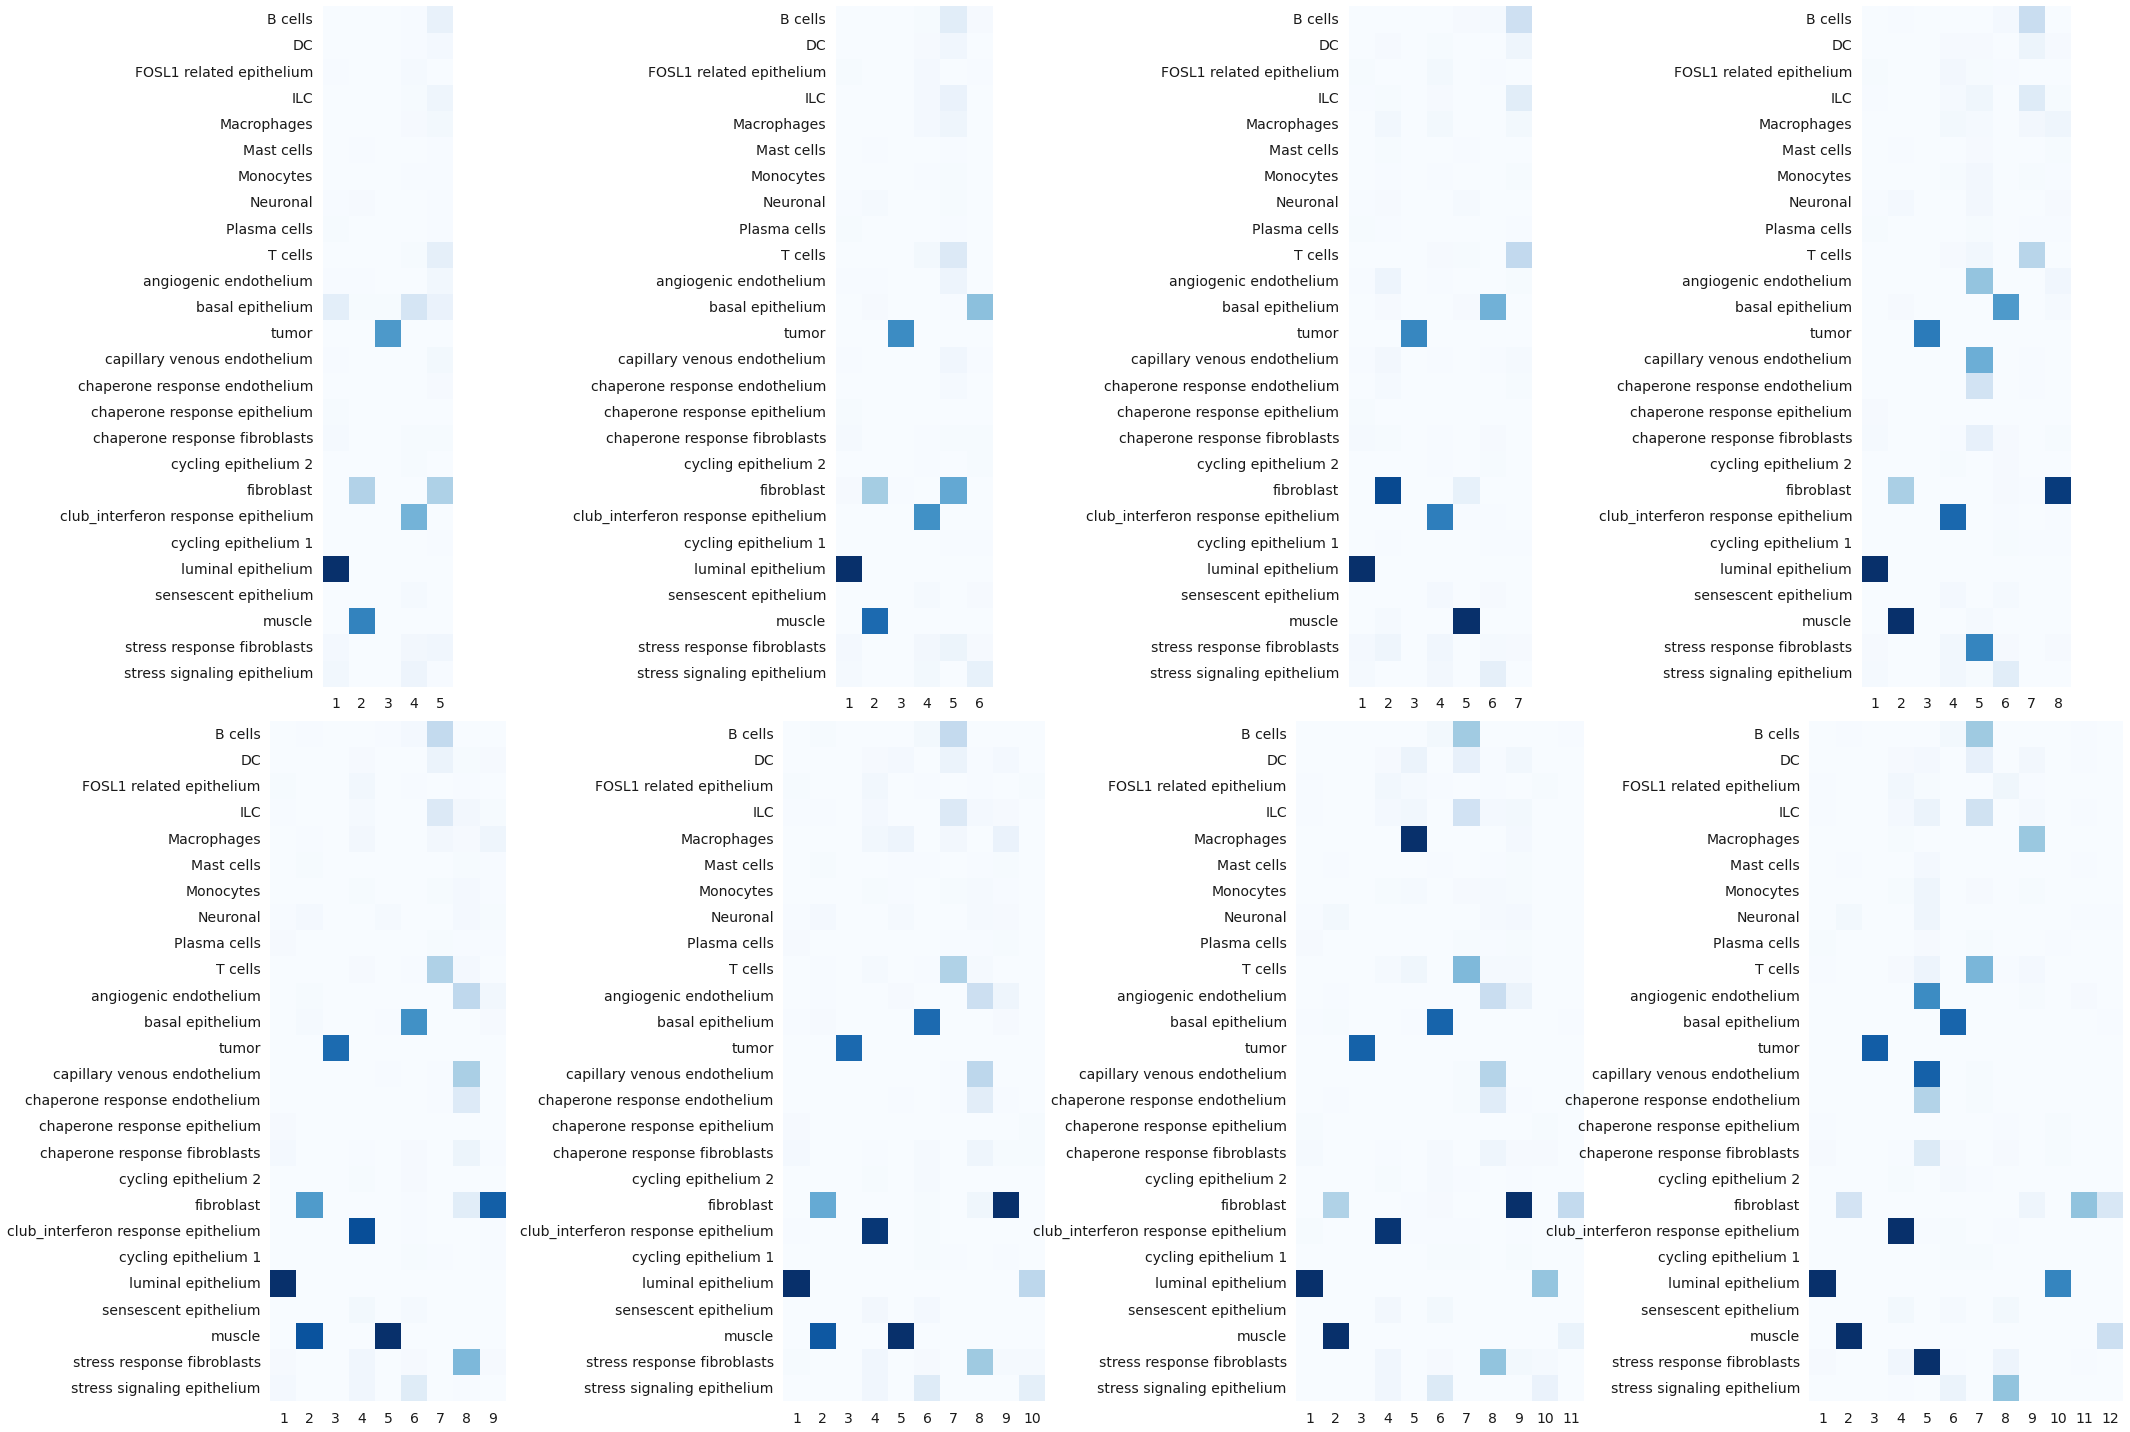

In [20]:
# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(30, 20))

for i, n_components in enumerate(component_range):

    # Drop the redundant cell types prior to plotting
    nmf_res_for_plotting = nmf_res_dict[n_components].copy()
    #nmf_res_for_plotting = nmf_res_for_plotting.loc[~(nmf_res_for_plotting.max(axis=1) < nmf_res_for_plotting.stack().quantile(0.9))]

    # Determine the position of the subplot on the grid
    row = i // 4
    col = i % 4
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(nmf_res_for_plotting, cmap='Blues', square=True, ax=axs[row, col], vmax=100,cbar=False)

plt.tight_layout()
plt.show()


In [ ]:
# Select the best number of factors and annotate them
tissue_region_names = {1:'Luminal epithelium', 2:'Muscle', 3:'Tumor', 4:'Intermediate epithelium',
                       5:'Endothelium', 6:'Basal epithelium', 7:'Immune', 8:'Fibroblast'}

# Sorting out the colors for tissue regions (Set2 palette)
sorted_region_names = [np.sort(list(tissue_region_names.values())).tolist()[i] for i in [7,4,0,3,5,1,2,6]]
tissue_region_colors = ['#fc8d62','#8da0cb','#66c2a5','#ffd92f','#a6d854','#e78ac3','#e5c494','#b3b3b3']
region_colors_dict = dict(zip(sorted_region_names,tissue_region_colors))

# Number 8 is the best fit
tissue_regions = nmf_res_dict[8].copy().rename(columns=tissue_region_names)

In [ ]:

# Spot identity is determined by simply choosing the factor with the highest nmf weight
obs_data = cell_mapping_dat.obs.copy().reset_index(drop=True)
nmf_obs_weights = pd.DataFrame(nmf_cell_weights_dict[8],columns=list(tissue_region_names.values()),index=cell_mapping_dat.obs_names)
nmf_obs_annot = nmf_obs_weights.idxmax(axis=1)

obs_data.index = cell_mapping_dat.obs_names
obs_data['nmf_weight_based_regions'] = nmf_obs_annot
nmf_obs_annot.value_counts()


In [ ]:
samples = get_sample_ids()
for sample in samples:
    slide = adata_slides[sample]
    slide.obs['predicted_region'] = obs_data.loc[slide.obs_names]['nmf_weight_based_regions'].astype('category')
    slide_categories = [s for s in sorted_region_names if s in slide.obs['predicted_region'].cat.categories]
    slide.obs['predicted_region'] = slide.obs['predicted_region'].cat.reorder_categories(slide_categories)

    # Get the colors considering some might be missing
    slide.uns['predicted_region_colors'] = [region_colors_dict[region] for region in slide_categories]

    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='predicted_region',size=1.3,ax=ax_plotting[0],show=False)
    sc.pl.spatial(slide,color='joint_leiden_clusters',size=1.3,ax=ax_plotting[1],show=False)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_obs_weight_based_tissue_regions_spatial.pdf')
    plt.clf()
    

In [ ]:
# This is in ALL samples
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    
    slide = adata_slides[sample]
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)
    
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat
sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='bwr',ax=ax,annot=True,fmt='.1f',center=0,vmin=-30,vmax=30)
plt.savefig('./plots/tissue_region_interaction_heatmap_all_samples.pdf')
plt.show()

In [ ]:
PCa_samples = get_sample_ids('PCa')
# This is in PCa samples
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in PCa_samples:
    slide = adata_slides[sample]
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat

sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='bwr',ax=ax,annot=True,fmt='.1f',center=0,vmin=-30,vmax=30)
plt.savefig('./plots/tissue_region_interaction_heatmap_PCa_samples.pdf')
plt.show()

In [ ]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_'+run_name+'.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


In [ ]:
from scripts.utils import save_to_pickle
save_to_pickle(adata_slides,'./data/slides_with_cell_mapping_based_regions.pkl')